In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import tensorflow as tf
%matplotlib inline

In [2]:
target_col = 'close_btc'

In [3]:
df2 = pd.read_csv('contents/BTC-USD.csv')
df2 = df2.rename(columns={"Date":"time", "Open":"open_btc", "High":"high_btc", "Low":"low_btc", "Close":"close_btc", "Volume":"volume_btc"})
df2 = df2.drop('Adj Close', axis=1)
df2 = df2.set_index('time')
df2.head()

,open_btc,high_btc,low_btc,close_btc,volume_btc
time,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0


In [4]:
df_eur = pd.read_csv('contents/EURUSD=X.csv')
df_eur = df_eur.rename(columns={"Date":"time", "Close":"close_eur"})
df_eur = df_eur.set_index('time')
df3 = df_eur[['close_eur']]
df3.head()

,close_eur
time,
2014-12-09,1.231512
2014-12-10,1.239495
2014-12-11,1.247396
2014-12-12,1.239495
2014-12-15,1.246354


In [5]:
df_cny = pd.read_csv('contents/CNY=X.csv')
df_cny = df_cny.rename(columns={"Date":"time", "Close":"close_cny"})
df_cny = df_cny.set_index('time')
df4 = df_cny[['close_cny']]
df4.head()

,close_cny
time,
2014-12-09,6.1630
2014-12-10,6.1778
2014-12-11,6.1666
2014-12-12,6.1786
2014-12-15,6.1769


In [6]:
df = pd.concat([df2, df3, df4], axis=1)
df = df.dropna()
df.head()

,open_btc,high_btc,low_btc,close_btc,volume_btc,close_eur,close_cny
time,,,,,,,
2014-12-09,361.894989,363.066986,344.950989,352.218994,32915500.0,1.231512,6.1630
2014-12-10,352.204987,352.384003,346.364990,346.364990,16427700.0,1.239495,6.1778
2014-12-11,344.339996,361.356995,338.763000,350.506012,32431300.0,1.247396,6.1666
2014-12-12,350.833008,352.983002,349.290985,352.541992,16989800.0,1.239495,6.1786
2014-12-15,351.360992,351.815002,344.933990,345.345001,17264200.0,1.246354,6.1769


In [7]:
# Splits and shuffles the dataset into train, validation and test sets.

def train_val_test_split(df, validation_size=0.2, test_size=0.2):
    return np.split(df, [int(.8*len(df)), int(.9*len(df))]) 

train_df, validation_df, test_df = train_val_test_split(df)

In [8]:
train_df

,open_btc,high_btc,low_btc,close_btc,volume_btc,close_eur,close_cny
time,,,,,,,
2014-12-09,361.894989,363.066986,344.950989,352.218994,3.291550e+07,1.231512,6.1630
2014-12-10,352.204987,352.384003,346.364990,346.364990,1.642770e+07,1.239495,6.1778
2014-12-11,344.339996,361.356995,338.763000,350.506012,3.243130e+07,1.247396,6.1666
2014-12-12,350.833008,352.983002,349.290985,352.541992,1.698980e+07,1.239495,6.1786
2014-12-15,351.360992,351.815002,344.933990,345.345001,1.726420e+07,1.246354,6.1769
...,...,...,...,...,...,...,...
2019-10-23,8076.228516,8092.999512,7469.322754,7514.671875,2.194288e+10,1.112929,7.0762
2019-10-24,7509.728027,7532.867676,7446.988770,7493.488770,1.626871e+10,1.113239,7.0646
2019-10-25,7490.703125,8691.540039,7479.984375,8660.700195,2.870507e+10,1.110396,7.0681


In [9]:
train_df.shape

(1273, 7)

In [10]:
validation_df.shape

(159, 7)

In [11]:
test_df.shape

(160, 7)

In [12]:
# Normalize values between 0-1 for every feature (each column is divided by column max value).

scaler = MinMaxScaler()
scaler.fit(train_df)

train_scaled = scaler.transform(train_df)
validation_scaled = scaler.transform(validation_df)
test_scaled = scaler.transform(test_df)

train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns,index=train_df.index)
validation_scaled_df = pd.DataFrame(validation_scaled, columns=validation_df.columns,index=validation_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns,index=test_df.index)

train_scaled_df.head()

,open_btc,high_btc,low_btc,close_btc,volume_btc,close_eur,close_cny
time,,,,,,,
2014-12-09,0.009767,0.007717,0.009538,0.009195,0.000556,0.907182,0.000000
2014-12-10,0.009255,0.007159,0.009616,0.008886,0.000190,0.944810,0.014581
2014-12-11,0.008840,0.007628,0.009198,0.009104,0.000545,0.982051,0.003547
2014-12-12,0.009183,0.007191,0.009777,0.009212,0.000202,0.944810,0.015369
2014-12-15,0.009211,0.007130,0.009537,0.008832,0.000209,0.977140,0.013695


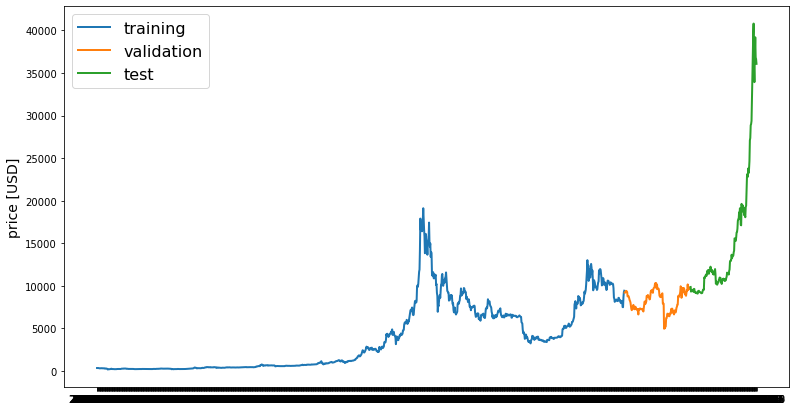

In [13]:
def line_plot(line1, line2, line3, label1=None, label2=None, label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    
line_plot(train_df[target_col], validation_df[target_col], test_df[target_col], 'training', 'validation', 'test', title='')

In [14]:
def extract_window_data(df, window_len=5):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        window_data.append(tmp.values)
    
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10):
#    train_data, validation_data, test_data = train_val_test_split(df)
#    X_train = extract_window_data(train_data, window_len)
#    X_val = extract_window_data(validation_data, window_len)
#    X_test = extract_window_data(test_data, window_len)
#    y_train = train_data[target_col][window_len:].values
#    y_val = validation_data[target_col][window_len:].values
#    y_test = test_data[target_col][window_len:].values

#    return X_train, X_val, X_test, y_train, y_val, y_test

    x = extract_window_data(df, window_len)
    y = df[target_col][window_len:].values
    
    return x, y

def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape =(input_data.shape[1],input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [15]:
np.random.seed(42)
window_len = 5
lstm_neurons = 200
epochs = 200
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [17]:
#X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_scaled, target_col, window_len=window_len)

X_train, y_train = prepare_data(train_scaled_df, target_col, window_len=window_len)
X_val, y_val = prepare_data(validation_scaled_df, target_col, window_len=window_len)
X_test, y_test = prepare_data(test_scaled_df, target_col, window_len=window_len)

In [18]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False, callbacks=[es, mc])

Epoch 1/200
40/40 [==============================] - ETA: 0s - loss: 0.0090
Epoch 00001: val_loss improved from inf to 0.00357, saving model to best_model.h5
40/40 [==============================] - 1s 21ms/step - loss: 0.0090 - val_loss: 0.0036
Epoch 2/200
39/40 [============================>.] - ETA: 0s - loss: 0.0042
Epoch 00002: val_loss did not improve from 0.00357
40/40 [==============================] - 0s 11ms/step - loss: 0.0041 - val_loss: 0.0090
Epoch 3/200
40/40 [==============================] - ETA: 0s - loss: 0.0071   
Epoch 00003: val_loss improved from 0.00357 to 0.00171, saving model to best_model.h5
40/40 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0017
Epoch 4/200
38/40 [===========================>..] - ETA: 0s - loss: 0.0035
Epoch 00004: val_loss improved from 0.00171 to 0.00140, saving model to best_model.h5
40/40 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 5/200
38/40 [===================

In [19]:
# load the best modell
model = load_model('best_model.h5')

# evaluate the model
train_acc = model.evaluate(X_train, y_train, verbose=0)
test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.001, Test: 0.003


In [20]:
preds = model.predict(X_test).squeeze()

arr = np.zeros([preds.shape[0], 7])
arr[:, 3] = preds

res = scaler.inverse_transform(arr)

df_res = pd.DataFrame(res, columns=df.columns)

df_res.head()

,open_btc,high_btc,low_btc,close_btc,volume_btc,close_eur,close_cny
0,176.897003,215.240997,171.509995,9506.221400,7860650.0,1.039047,6.163
1,176.897003,215.240997,171.509995,9455.153177,7860650.0,1.039047,6.163
2,176.897003,215.240997,171.509995,9450.980450,7860650.0,1.039047,6.163
3,176.897003,215.240997,171.509995,9475.172562,7860650.0,1.039047,6.163
4,176.897003,215.240997,171.509995,9611.354490,7860650.0,1.039047,6.163


In [21]:
res

array([[1.76897003e+02, 2.15240997e+02, 1.71509995e+02, ...,
        7.86065000e+06, 1.03904700e+00, 6.16300000e+00],
       [1.76897003e+02, 2.15240997e+02, 1.71509995e+02, ...,
        7.86065000e+06, 1.03904700e+00, 6.16300000e+00],
       [1.76897003e+02, 2.15240997e+02, 1.71509995e+02, ...,
        7.86065000e+06, 1.03904700e+00, 6.16300000e+00],
       ...,
       [1.76897003e+02, 2.15240997e+02, 1.71509995e+02, ...,
        7.86065000e+06, 1.03904700e+00, 6.16300000e+00],
       [1.76897003e+02, 2.15240997e+02, 1.71509995e+02, ...,
        7.86065000e+06, 1.03904700e+00, 6.16300000e+00],
       [1.76897003e+02, 2.15240997e+02, 1.71509995e+02, ...,
        7.86065000e+06, 1.03904700e+00, 6.16300000e+00]])

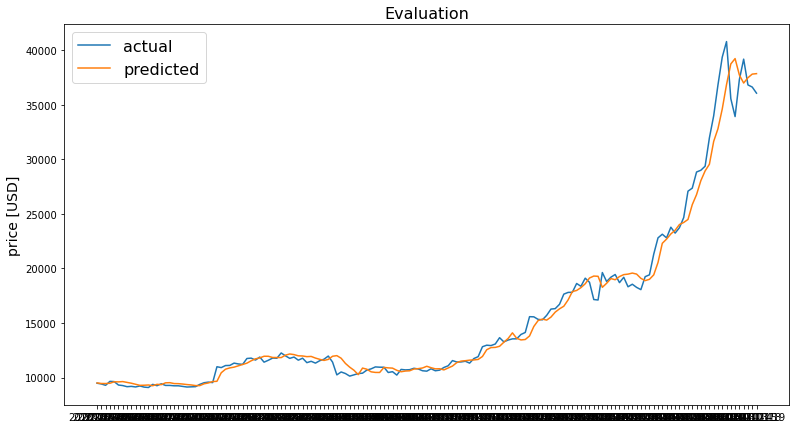

In [22]:
predicted_closing_prices = df_res[target_col].values
actual_closing_prices = test_df[target_col][window_len:]
predicted_closing_prices = pd.Series(index=actual_closing_prices.index, data=predicted_closing_prices)

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(actual_closing_prices, label='actual')
ax.plot(predicted_closing_prices, label='predicted')
ax.set_ylabel('price [USD]', fontsize=14)
ax.set_title('Evaluation', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [23]:
res_data = {'time': test_df.index[window_len:], 'actual': test_df[target_col][window_len:], 'preds' :predicted_closing_prices}
res_df = pd.DataFrame(data=res_data)
res_df = res_df.set_index('time')

In [24]:
res_df.head()

,actual,preds
time,,
2020-06-17,9480.254883,9506.221400
2020-06-18,9411.840820,9455.153177
2020-06-19,9288.018555,9450.980450
2020-06-22,9648.717773,9475.172562
2020-06-23,9629.658203,9611.354490


In [25]:
res_df.to_json(r'results.json')